# "Cross-validation" des modèles

In [1]:
learning_rate = 0.04
num_epochs = 400
N = 100
N_cv = 40
seed = 42
batch_size = N//4
batch_size = N//2

N_test = 0
N_test = 1000
N_scan = 9

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Creer des données synthetiques 

In [3]:
def get_data(
            N = N,
            p0 = 0.05,
            theta0 = 0,
            wt = np.pi/20,
            theta_std = np.pi/6,
            seed=seed):
    np.random.seed(42)
    theta = np.random.randn(N)*theta_std
    a = (theta-theta0)/wt
    p = 1/(1+np.exp(-a))
    
    p = p0/2 + (1-p0) * p
    y = np.random.rand(N) < p
    return theta, p, y


In [4]:
import torch
from torch.utils.data import TensorDataset, DataLoader
torch.set_default_tensor_type('torch.DoubleTensor')
criterion = torch.nn.BCELoss()

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, bias=True, logit0=-1):
        super(LogisticRegressionModel, self).__init__()
        self.linear = torch.nn.Linear(1, 1, bias=bias)    
        self.logit0 = torch.nn.Parameter(logit0*torch.ones(1))

    def forward(self, x):
        out = self.logit0.sigmoid()/2 + (1-self.logit0.sigmoid())*torch.sigmoid(self.linear(x))
        return out

def fit_data(theta, y, 
                learning_rate =learning_rate,
                num_epochs = num_epochs,
                batch_size = batch_size,
                verbose=False):

    logistic_model = LogisticRegressionModel()

    labels = torch.Tensor(y[:, None])
    Theta = torch.Tensor(theta[:, None])

    loader = DataLoader(TensorDataset(Theta, labels), batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate/len(loader))
    
    for epoch in range(int(num_epochs)):
        losses = []
        for Theta_, labels_ in loader:
            optimizer.zero_grad()
            outputs = logistic_model(Theta_)
            loss = criterion(outputs, labels_)
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        
        if verbose and (epoch % (num_epochs//32) == 0) : 
            print(f"Iteration: {epoch} - Loss: {np.mean(losses):.5f}")

    logistic_model.eval()
    return logistic_model, np.mean(losses)

In [5]:
%%timeit
theta, p, y = get_data()

15.7 µs ± 129 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
theta, p, y = get_data()
logistic_model, loss = fit_data(theta, y, verbose=True)

Iteration: 0 - Loss: 0.67980
Iteration: 12 - Loss: 0.60432
Iteration: 24 - Loss: 0.55851
Iteration: 36 - Loss: 0.52448
Iteration: 48 - Loss: 0.49998
Iteration: 60 - Loss: 0.48212
Iteration: 72 - Loss: 0.46865
Iteration: 84 - Loss: 0.45877
Iteration: 96 - Loss: 0.45117
Iteration: 108 - Loss: 0.44533
Iteration: 120 - Loss: 0.44084
Iteration: 132 - Loss: 0.43734
Iteration: 144 - Loss: 0.43463
Iteration: 156 - Loss: 0.43244
Iteration: 168 - Loss: 0.43077
Iteration: 180 - Loss: 0.42949
Iteration: 192 - Loss: 0.42833
Iteration: 204 - Loss: 0.42748
Iteration: 216 - Loss: 0.42682
Iteration: 228 - Loss: 0.42631
Iteration: 240 - Loss: 0.42586
Iteration: 252 - Loss: 0.42561
Iteration: 264 - Loss: 0.42530
Iteration: 276 - Loss: 0.42509
Iteration: 288 - Loss: 0.42498
Iteration: 300 - Loss: 0.42481
Iteration: 312 - Loss: 0.42471
Iteration: 324 - Loss: 0.42462
Iteration: 336 - Loss: 0.42459
Iteration: 348 - Loss: 0.42452
Iteration: 360 - Loss: 0.42451
Iteration: 372 - Loss: 0.42453
Iteration: 384 - L

loss= 0.4244080497139457


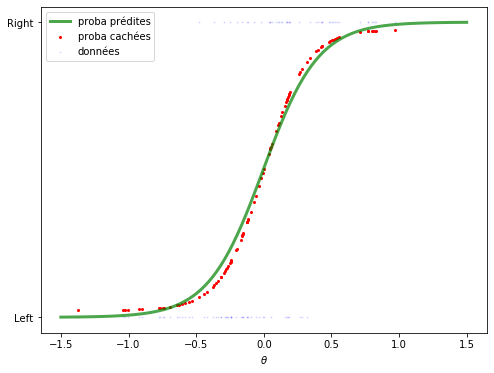

In [7]:
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();


In [8]:
%%timeit
logistic_model, loss = fit_data(theta, y, verbose=False)

621 ms ± 3.27 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## validation

loss= tensor(0.4244, grad_fn=<BinaryCrossEntropyBackward>)


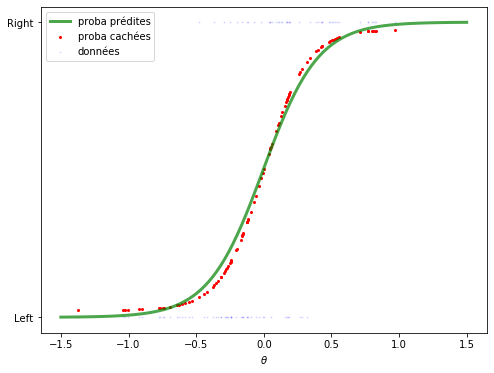

In [9]:
theta, p, y = get_data() # nouvelles données 

labels = torch.Tensor(y[:, None])
Theta = torch.Tensor(theta[:, None])
outputs = logistic_model(Theta)
loss = criterion(outputs, labels)
print('loss=', loss)
plt.figure(figsize = (8,6)) 
plt.scatter(theta, p, s=4, color = 'r', label='proba cachées')
plt.scatter(theta, y, s=1, alpha=.1, color = 'b', label='données')
x_values = np.linspace(-1.5, 1.50, 100)[:, None]
y_values = logistic_model(torch.Tensor(x_values)).detach().numpy()
plt.plot(x_values, y_values, 'g', alpha=.7, lw=3, label='proba prédites')
plt.xlabel(r'$\theta$')
plt.yticks([0.,1.],['Left', 'Right']);
plt.legend();

## influence du nombre de trials

In [10]:
Ns = np.logspace(1, 3, N_scan, base=10)
Ns_, losses, loss_Ps, loss_P0s = [], [], [], []
for N_ in Ns:
    for i_CV in range(N_cv):
        theta, p, y = get_data(N=int(N_), seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        P = torch.Tensor(p[:, None])
        
        outputs = logistic_model(Theta)
        loss = criterion(outputs, labels).item()
        
        loss_P = criterion(outputs, P).item() 
        loss_P0 = criterion(P, P).item()
        if i_CV==0: print(f"N: {int(N_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        loss_P0s.append(loss_P0)
        Ns_.append(N_)
        loss_Ps.append(loss_P)
        losses.append(loss)

N: 10, Loss: 0.46639, loss_P: 0.45901, loss_P0: 0.38791
N: 17, Loss: 0.44287, loss_P: 0.43855, loss_P0: 0.38791
N: 31, Loss: 0.38909, loss_P: 0.39531, loss_P0: 0.38791
N: 56, Loss: 0.38376, loss_P: 0.39204, loss_P0: 0.38791
N: 100, Loss: 0.38552, loss_P: 0.39201, loss_P0: 0.38791
N: 177, Loss: 0.38840, loss_P: 0.39131, loss_P0: 0.38791
N: 316, Loss: 0.38578, loss_P: 0.38982, loss_P0: 0.38791
N: 562, Loss: 0.38215, loss_P: 0.38878, loss_P0: 0.38791
N: 1000, Loss: 0.38185, loss_P: 0.38986, loss_P0: 0.38791


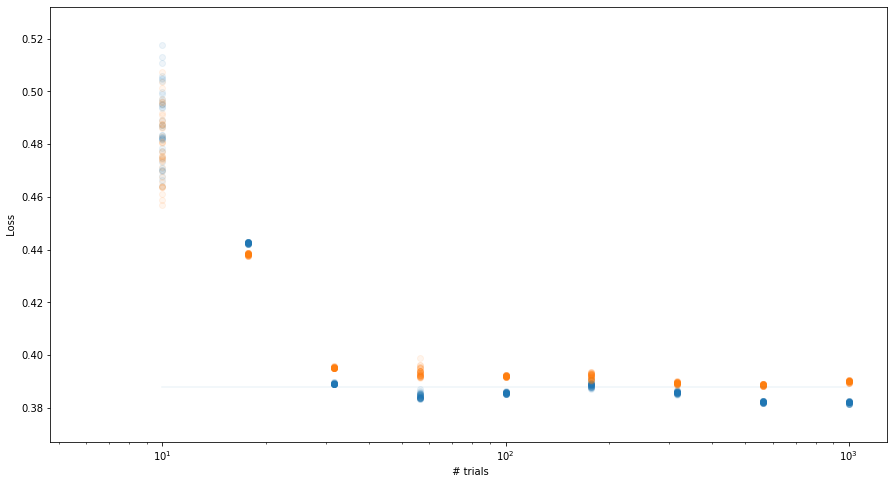

In [11]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(Ns_, losses, alpha=3/N_cv, label='loss')
ax.scatter(Ns_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(Ns_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # trials')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')

## influence du nombre du learning rate


In [12]:
learning_rates = learning_rate * np.logspace(-1, 1, N_scan, base=10)
learning_rates_, losses, loss_Ps, loss_P0s = [], [], [], []
for learning_rate_ in learning_rates:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, learning_rate=learning_rate_, verbose=False)

        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"learning_rate: {learning_rate_:.5f}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        learning_rates_.append(learning_rate_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

learning_rate: 0.00400, Loss: 0.45279, loss_P: 0.45644, loss_P0: 0.38791
learning_rate: 0.00711, Loss: 0.42764, loss_P: 0.43178, loss_P0: 0.38791
learning_rate: 0.01265, Loss: 0.43278, loss_P: 0.43673, loss_P0: 0.38791
learning_rate: 0.02249, Loss: 0.39480, loss_P: 0.40014, loss_P0: 0.38791
learning_rate: 0.04000, Loss: 0.38651, loss_P: 0.39263, loss_P0: 0.38791
learning_rate: 0.07113, Loss: 0.38544, loss_P: 0.39207, loss_P0: 0.38791
learning_rate: 0.12649, Loss: 0.38536, loss_P: 0.39204, loss_P0: 0.38791
learning_rate: 0.22494, Loss: 0.38554, loss_P: 0.39233, loss_P0: 0.38791
learning_rate: 0.40000, Loss: 0.38571, loss_P: 0.39235, loss_P0: 0.38791


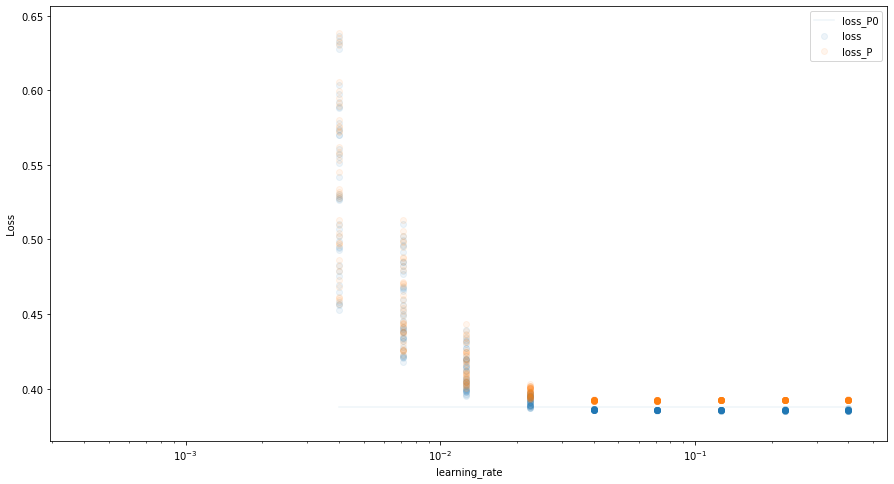

In [13]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(learning_rates_, losses, alpha=3/N_cv, label='loss')
ax.scatter(learning_rates_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(learning_rates_, loss_P0s, label='loss_P0')

ax.set_xlabel('learning_rate')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence du nombre d'epochs

In [14]:
num_epochss = num_epochs * np.logspace(-1, 1, N_scan, base=10)
num_epochss_, losses, loss_Ps, loss_P0s = [], [], [], []
for num_epochs_ in num_epochss:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, num_epochs=int(num_epochs_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"num_epochs: {int(num_epochs_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        num_epochss_.append(num_epochs_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

num_epochs: 40, Loss: 0.49999, loss_P: 0.50320, loss_P0: 0.38791
num_epochs: 71, Loss: 0.51941, loss_P: 0.52218, loss_P0: 0.38791
num_epochs: 126, Loss: 0.40299, loss_P: 0.40800, loss_P0: 0.38791
num_epochs: 224, Loss: 0.38869, loss_P: 0.39457, loss_P0: 0.38791
num_epochs: 400, Loss: 0.38608, loss_P: 0.39245, loss_P0: 0.38791
num_epochs: 711, Loss: 0.38540, loss_P: 0.39206, loss_P0: 0.38791
num_epochs: 1264, Loss: 0.38549, loss_P: 0.39224, loss_P0: 0.38791
num_epochs: 2249, Loss: 0.38558, loss_P: 0.39228, loss_P0: 0.38791
num_epochs: 4000, Loss: 0.38547, loss_P: 0.39235, loss_P0: 0.38791


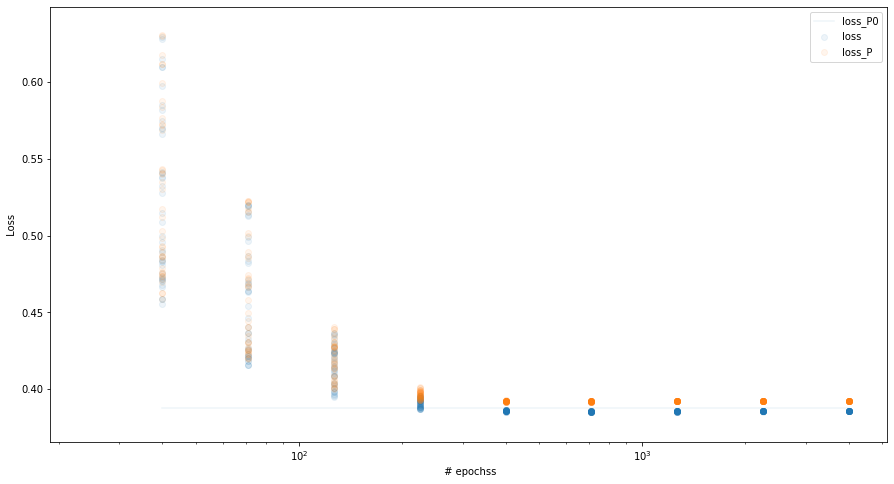

In [15]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(num_epochss_, losses, alpha=3/N_cv, label='loss')
ax.scatter(num_epochss_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(num_epochss_, loss_P0s, label='loss_P0')

ax.set_xlabel(' # epochss')
#ax.set_xlim(np.min(learning_rates_), np.max(learning_rates_))
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');

## influence de la taille du minibatch

In [16]:
batch_sizes = N * np.logspace(-3, 0, N_scan, base=2)
batch_sizes_, losses, loss_Ps, loss_P0s = [], [], [], []
for batch_size_ in batch_sizes:
    for i_CV in range(N_cv):
        theta, p, y = get_data(seed=seed+i_CV)
        logistic_model, loss = fit_data(theta, y, batch_size=int(batch_size_), verbose=False)
        
        if N_test>0: theta, p, y = get_data(N=N_test) # nouvelles données 
        labels = torch.Tensor(y[:, None])
        Theta = torch.Tensor(theta[:, None])
        outputs = logistic_model(Theta)

        loss = criterion(outputs, labels).item()
        loss_P = criterion(outputs, torch.Tensor(p[:, None])).item()
        loss_P0 = criterion(torch.Tensor(p[:, None]), torch.Tensor(p[:, None])).item()
        if i_CV==0: 
            print(f"batch_size: {int(batch_size_)}, Loss: {loss:.5f}, loss_P: {loss_P:.5f}, loss_P0: {loss_P0:.5f}")
        batch_sizes_.append(batch_size_)
        loss_P0s.append(loss_P0)
        loss_Ps.append(loss_P)
        losses.append(loss)

batch_size: 12, Loss: 0.38540, loss_P: 0.39182, loss_P0: 0.38791
batch_size: 16, Loss: 0.38569, loss_P: 0.39236, loss_P0: 0.38791
batch_size: 21, Loss: 0.38639, loss_P: 0.39259, loss_P0: 0.38791
batch_size: 27, Loss: 0.38550, loss_P: 0.39194, loss_P0: 0.38791
batch_size: 35, Loss: 0.38587, loss_P: 0.39220, loss_P0: 0.38791
batch_size: 45, Loss: 0.38655, loss_P: 0.39252, loss_P0: 0.38791
batch_size: 59, Loss: 0.38549, loss_P: 0.39185, loss_P0: 0.38791
batch_size: 77, Loss: 0.38446, loss_P: 0.39191, loss_P0: 0.38791
batch_size: 100, Loss: 0.38578, loss_P: 0.39214, loss_P0: 0.38791


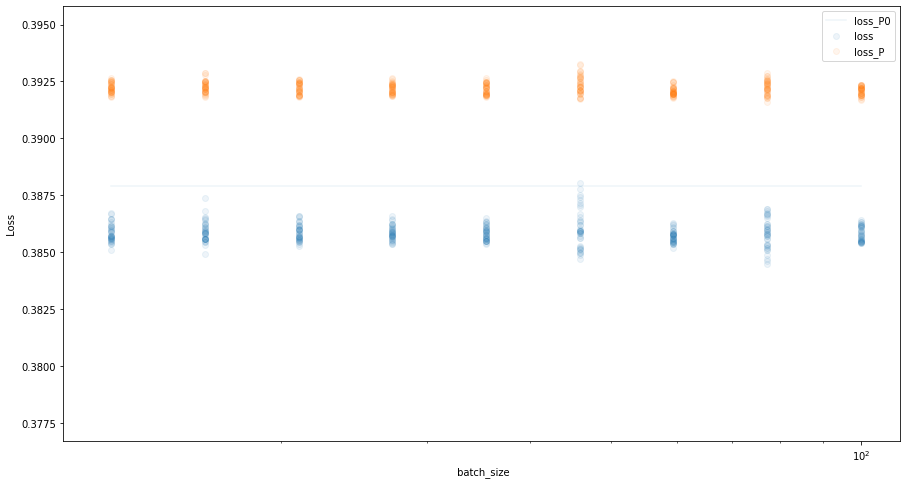

In [17]:
fig, ax = plt.subplots(figsize = (15, 8)) 
ax.scatter(batch_sizes_, losses, alpha=3/N_cv, label='loss')
ax.scatter(batch_sizes_, loss_Ps, alpha=3/N_cv, label='loss_P')
ax.plot(batch_sizes_, loss_P0s, label='loss_P0')

ax.set_xlabel(' batch_size')
ax.set_ylabel(' Loss ')
ax.set_xscale('log')
ax.legend(loc='best');